#Introduction

Name: Shivendra Shahi

Subject: Advanced Data Science/Architecture

Professor: Nicholas Brown

Project: Traffic Sign Classification


This final project implements the methodology written in a paper by Mrinal Haloi from IIT Guwahati ( https://arxiv.org/pdf/1511.02992v2.pdf ). This paper claims that it can achieve an accuracy which is more than state of the art model performance as well as better than human accuracy. I will implement the code and check if this findings are true; and at last I will compare this implementation with the one I did in Mini-Project-3 and explain the difference why this project performs better.

I have included comments for every block of codes for your convenience.


# Traffic Sign Classification


In this, we will fine-tune a pre-trained model for classifying raw pixels of traffic signs.

Here's what we'll go over:

- Overview of the traffic sign image dataset
- Build a dataset
- Use a pre-trained model from Torchvision
- Add a new *unknown* class and re-train the model



In [1]:
!nvidia-smi

Sat Dec 12 05:47:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install -q -U watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.5
torch 1.7.0+cu101
torchvision 0.8.1+cu101


## Importing Libraries

In [3]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Recognizing traffic signs

[German Traffic Sign Recognition Benchmark (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) contains more than 50,000 annotated images of 40+ traffic signs. Given an image, you'll have to recognize the traffic sign on it.

Download the dataset using wget and then unzip it

In [4]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2020-12-12 05:52:32--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M   114MB/s    in 2.3s    

2020-12-12 05:52:35 (114 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



### Exploration

Let's start by getting a feel of the data. The images for each traffic sign are stored in a separate directory. How many do we have?

In [5]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

We'll create 3 helper functions that use OpenCV and Torchvision to load  and show images:

In [6]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Let's have a look at some examples for each traffic sign:

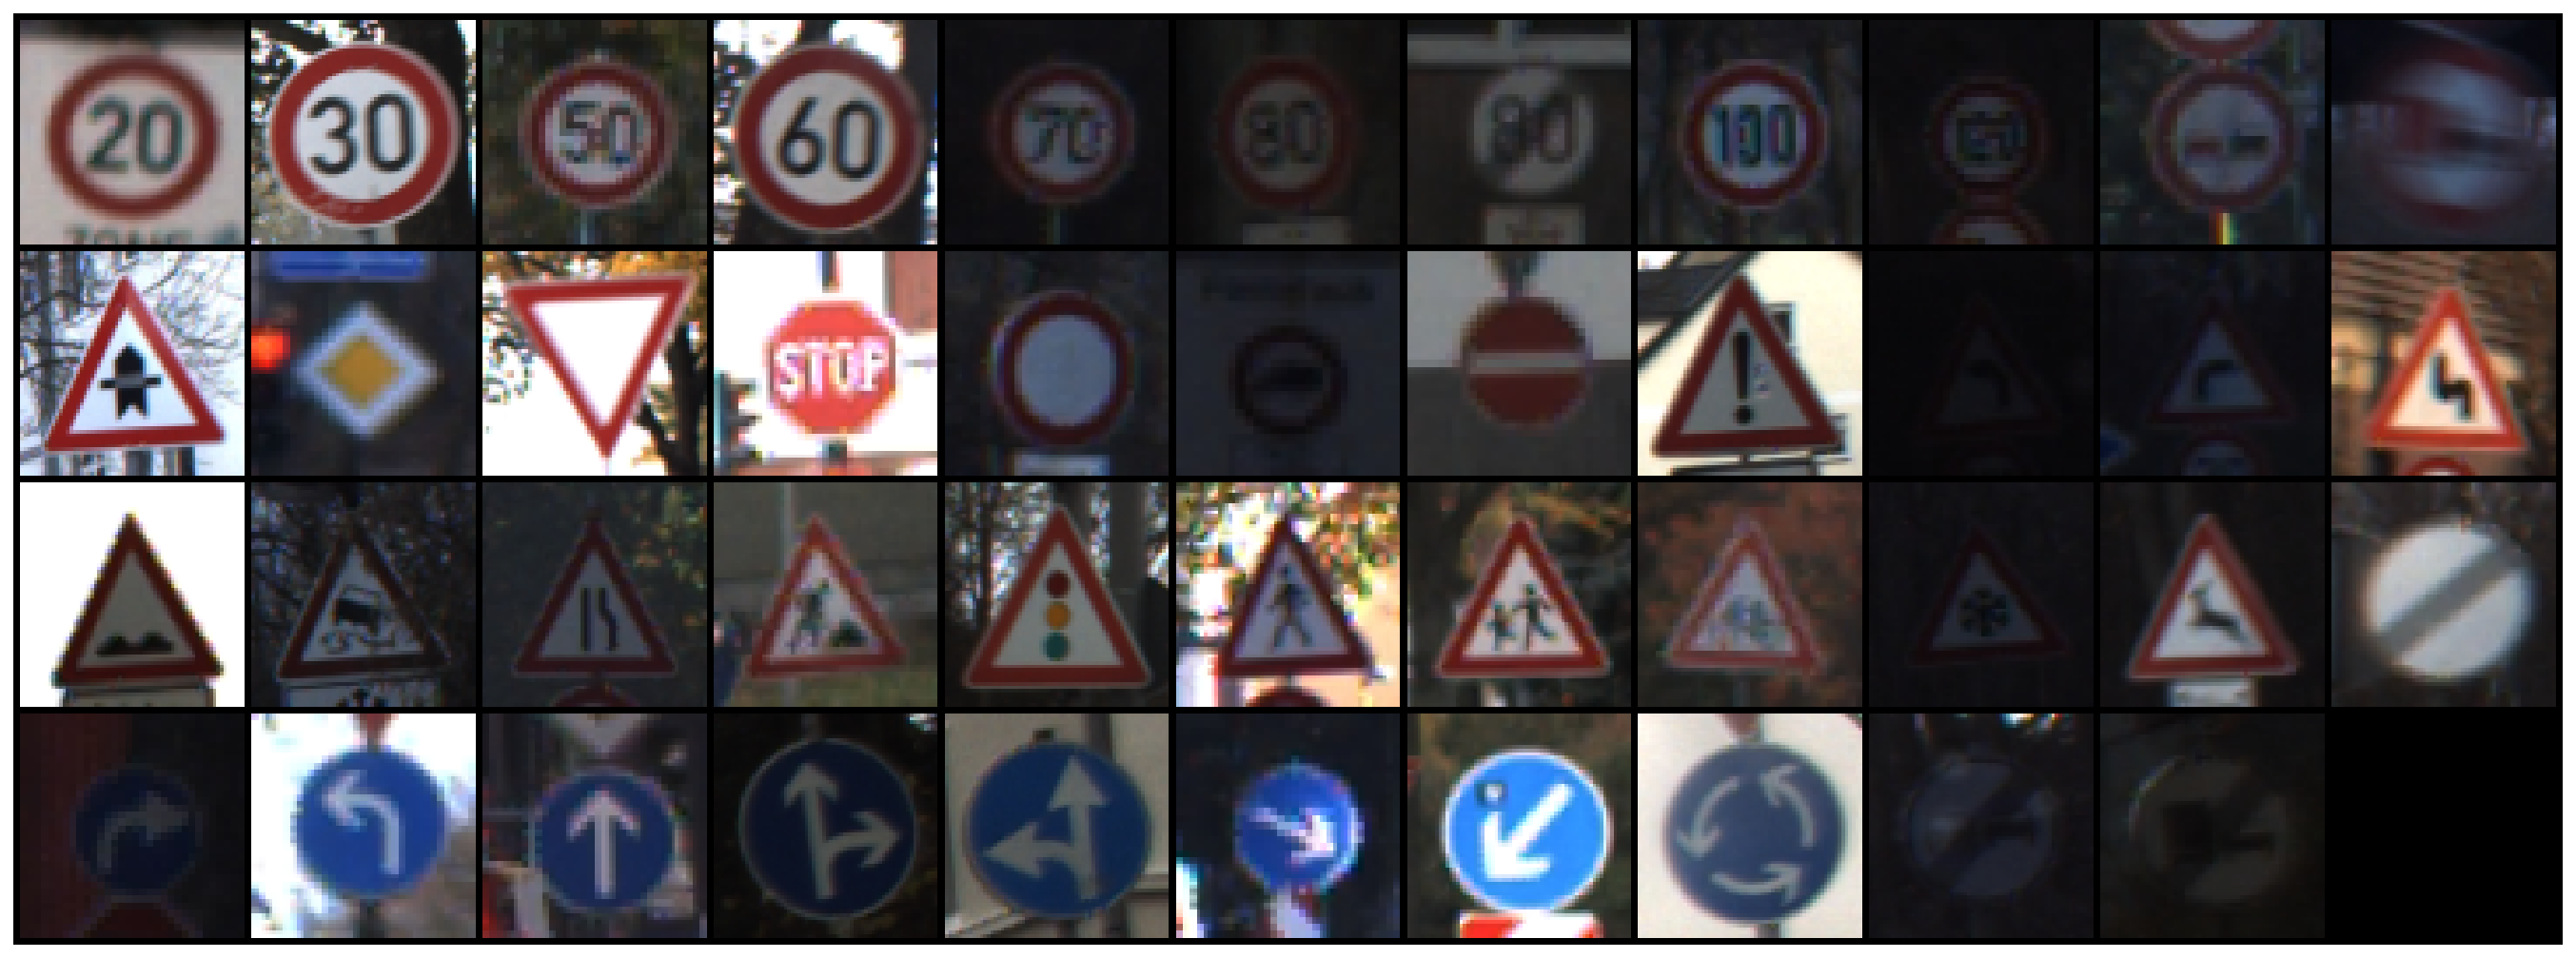

In [13]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

And here is a single sign:

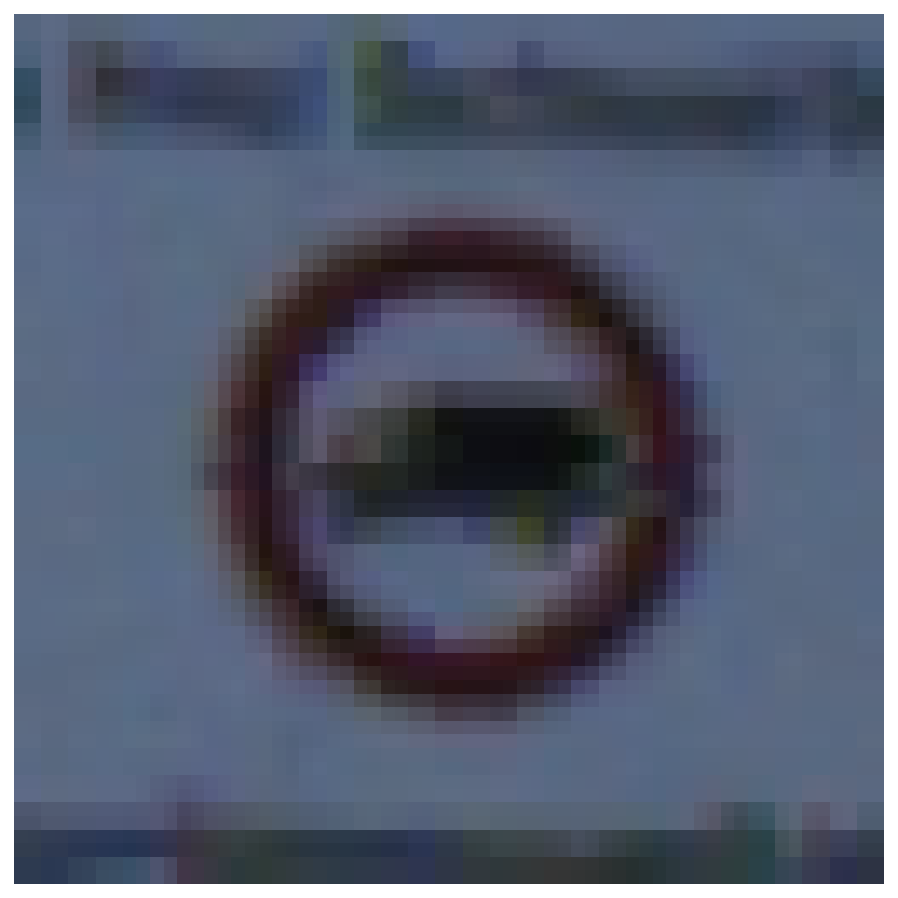

In [14]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

show_image(img_path)

## Building a dataset

To keep things simple, we'll focus on classifying some of the most used traffic signs:

In [15]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']

class_indices = [12, 13, 14, 17]

We'll copy the images files to a new directory, so it's easier to use the Torchvision's dataset helpers. Let's start with the directories for each class:

In [16]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

We'll reserve 80% of the images for training, 10% for validation, and 10% test for each class. We'll copy each image to the correct dataset directory:

In [17]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


We have some class imbalance, but it is not that bad. We'll ignore it.

We'll apply some image augmentation techniques to artificially increase the size of our training dataset:

In [18]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

We apply some random resizing, rotation, and horizontal flips. Finally, we normalize the tensors using preset values for each channel. This is a [requirement of the pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html) in Torchvision.

We'll create a PyTorch dataset for each image dataset folder and data loaders for easier training:

In [19]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

We'll also store the number of examples in each dataset and class names for later:

In [20]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 615, 'train': 4920, 'val': 615}

Let's have a look at some example images with applied transformations. We also need to reverse the normalization and reorder the color channels to get correct image data:

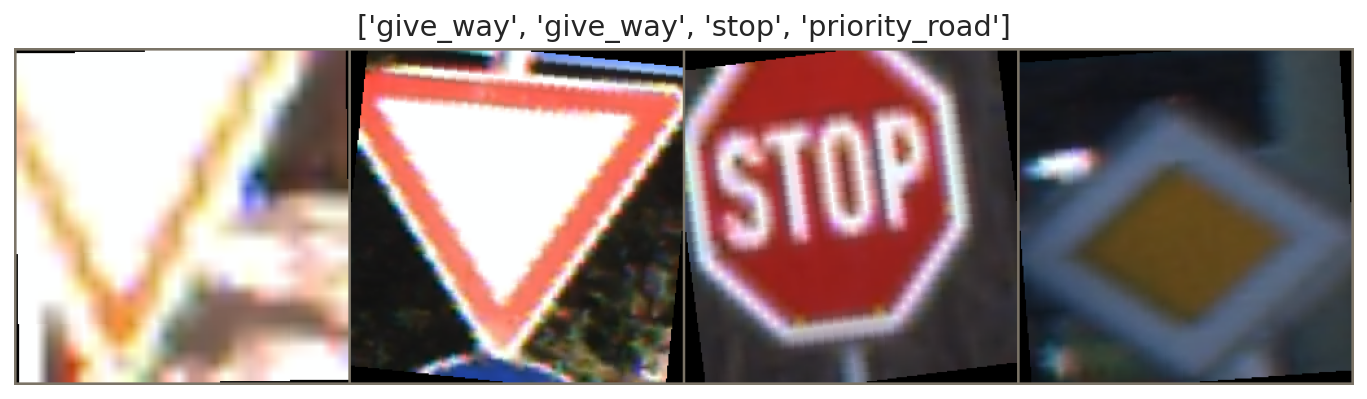

In [21]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Using a pre-trained model:

Our model will receive raw image pixels and try to classify them into one of four traffic signs.

Here, we'll use [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning) to copy the architecture of the very popular [ResNet](https://arxiv.org/abs/1512.03385) model. On top of that, we'll use the learned weights of the model from training on the [ImageNet dataset ](http://www.image-net.org/). All of this is made easy to use by Torchvision:

In [22]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

We reuse almost everything except the change of the output layer. This is needed because the number of classes in our dataset is different than ImageNet.

Let's create an instance of our model:

In [23]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


### Training

We'll write 3 helper functions to encapsulate the training and evaluation logic. Let's start with `train_epoch`:

In [24]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

We start by turning our model into train mode and go over the data. After getting the predictions, we get the class with maximum probability along with the loss, so we can calculate the epoch loss and accuracy.

Note that we're also using a learning rate scheduler (more on that later).

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

The evaluation of the model is pretty similar, except that we don't do any gradient calculations.

Let's put everything together:

In [28]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=5):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

We do a lot of string formatting and recording of the training history. The hard stuff gets delegated to the previous helper functions. We also want the best model, so the weights of the most accurate model(s) get stored during the training.

Let's train our first model:

In [29]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/5
----------
Train loss 0.08217283820950405 accuracy 0.9735772357723578
Val   loss 0.001035376336371233 accuracy 1.0

Epoch 2/5
----------
Train loss 0.05881109455552111 accuracy 0.9823170731707317
Val   loss 0.0023272249185997563 accuracy 0.9983739837398374

Epoch 3/5
----------
Train loss 0.05313808942646278 accuracy 0.9827235772357723
Val   loss 0.0072604413965375175 accuracy 0.9967479674796748

Epoch 4/5
----------
Train loss 0.041910671714311884 accuracy 0.9855691056910569
Val   loss 0.002991465205071761 accuracy 0.9983739837398374

Epoch 5/5
----------
Train loss 0.04266895287192762 accuracy 0.9873983739837399
Val   loss 0.00019093776176891777 accuracy 1.0

Best val accuracy: 1.0
CPU times: user 2min 46s, sys: 7.67 s, total: 2min 53s
Wall time: 2min 57s


Here's a little helper function that visualizes the training history for us:

In [32]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

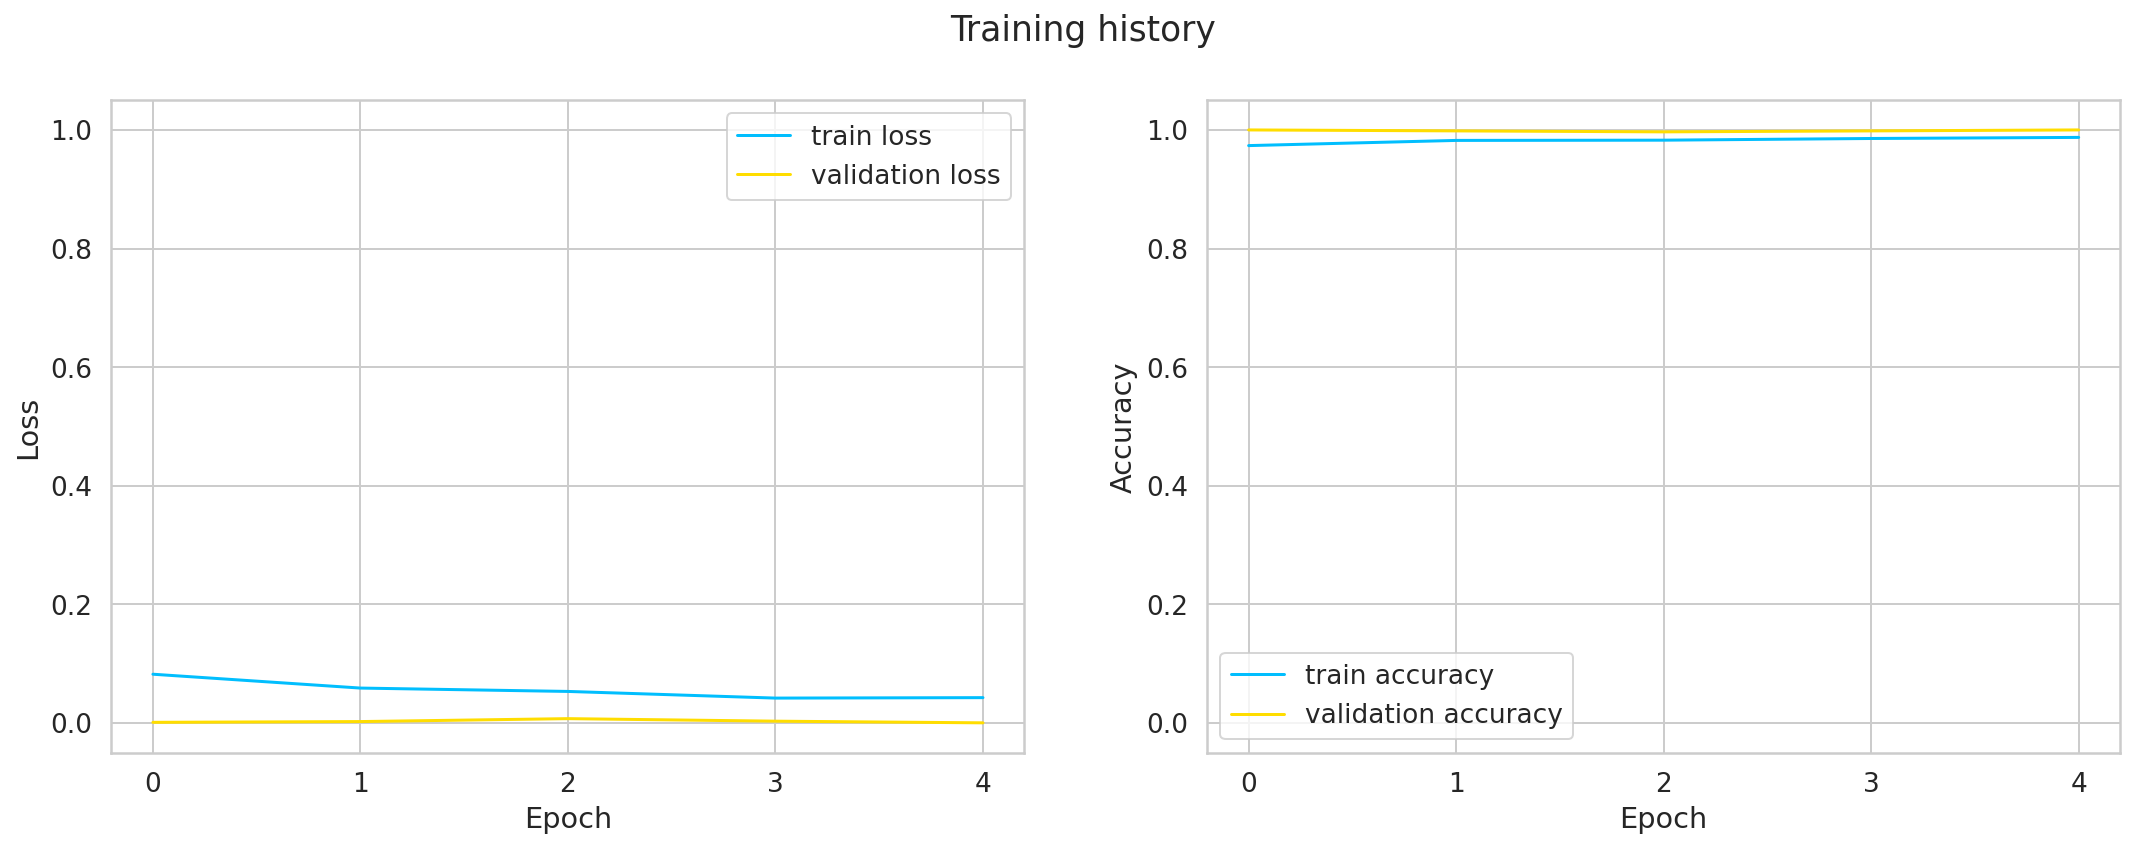

In [33]:
plot_training_history(history)

The pre-trained model is so good that we get very high accuracy and low loss after 5 epochs. Unfortunately, our validation set is too small to get some meaningful metrics from it.

### Evaluation

Let's see some predictions on traffic signs from the test set:

In [35]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

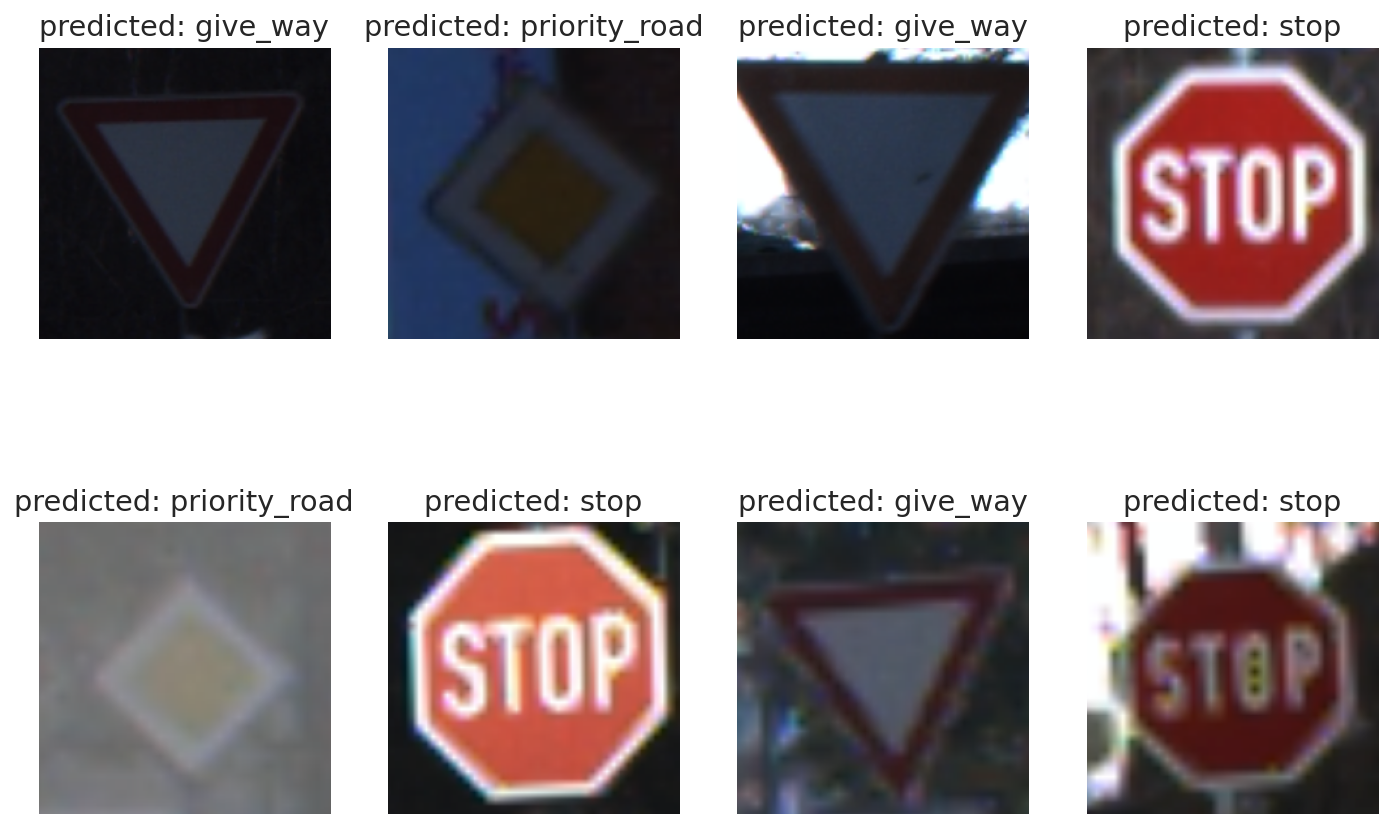

In [36]:
show_predictions(base_model, class_names, n_images=8)

Very good! Even the almost not visible *priority road* sign is classified correctly. Let's dive a bit deeper.

We'll start by getting the predictions from our model:

In [37]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [38]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [39]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       111
priority_road       1.00      1.00      1.00       210
         stop       1.00      1.00      1.00        78

     accuracy                           1.00       615
    macro avg       1.00      1.00      1.00       615
 weighted avg       1.00      1.00      1.00       615



The classification report shows us that our model is perfect, not something you see every day! Does this thing make any mistakes?

In [40]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

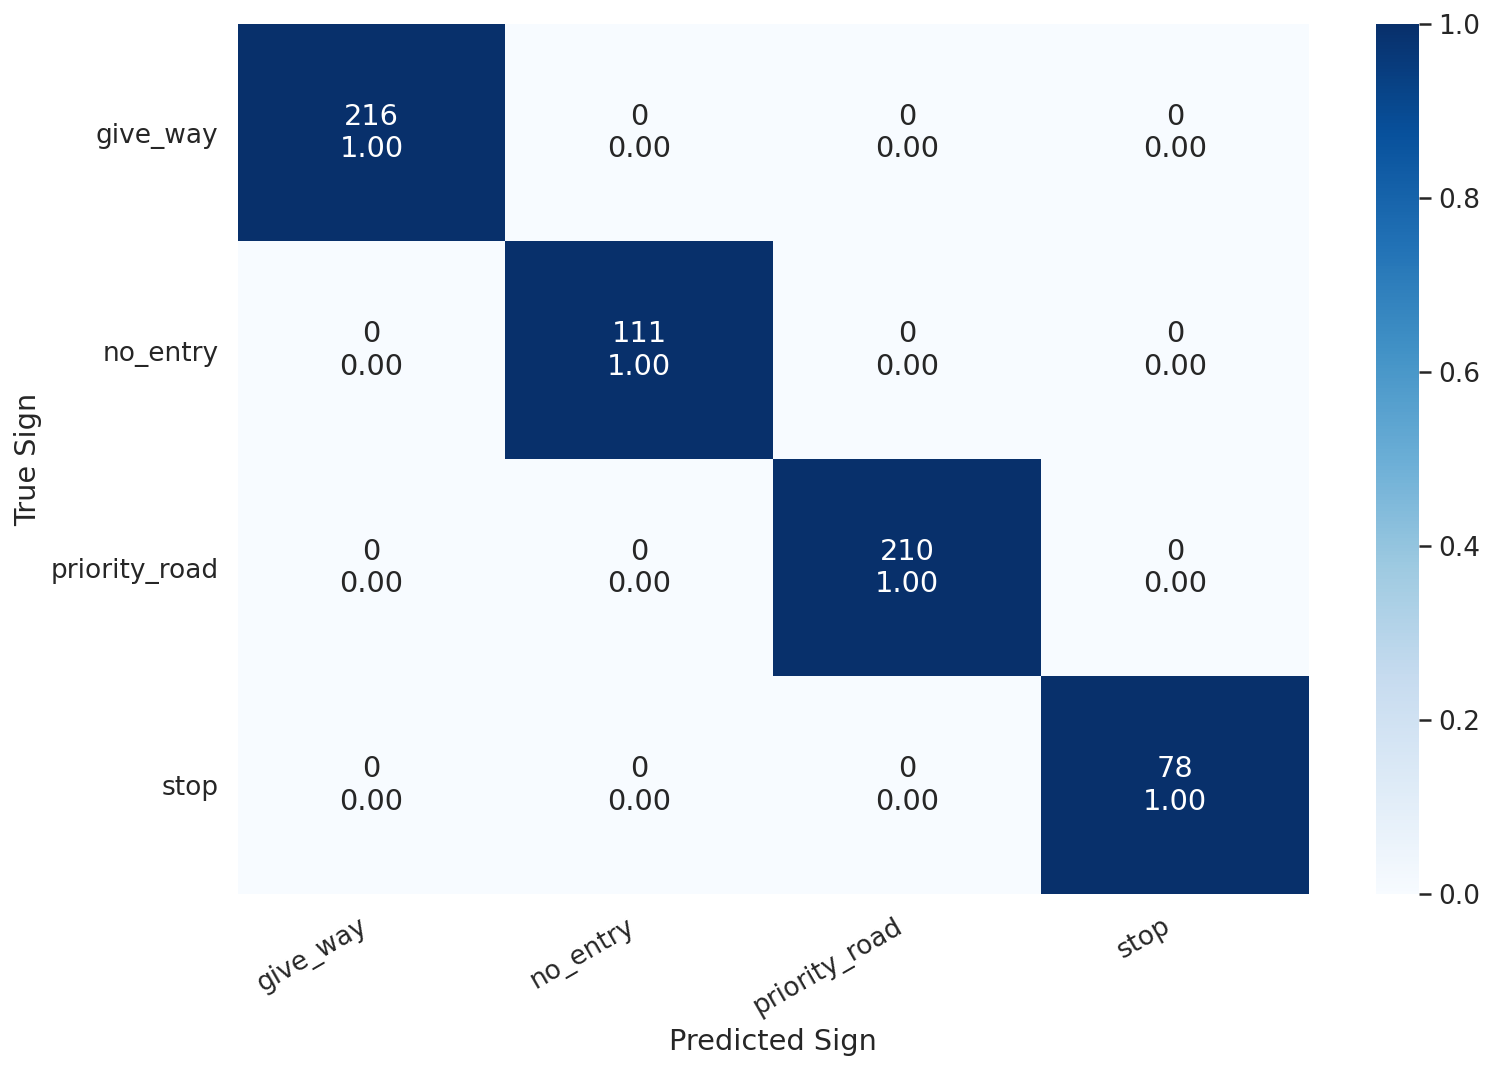

In [41]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

No, no mistakes here!

### Classifying unseen images

Ok, but how good our model will be when confronted with a real-world image? Let's check it out:

In [42]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 29.6MB/s]


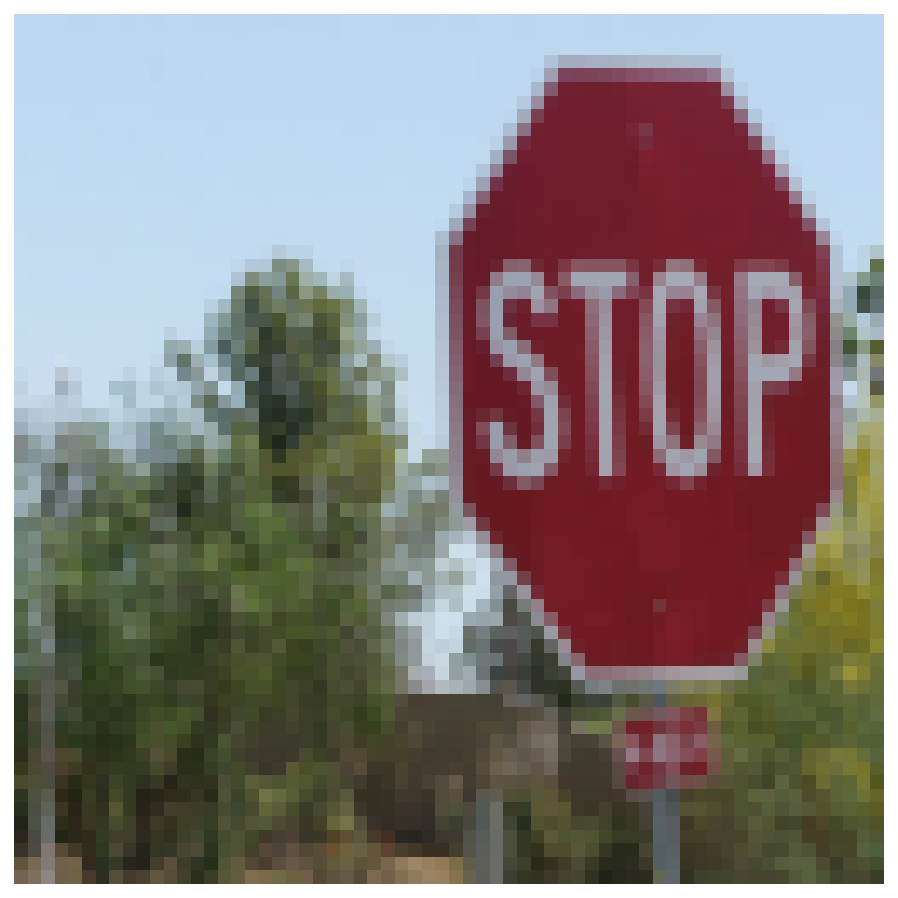

In [43]:
show_image('stop-sign.jpg')

For this, we'll have a look at the confidence for each class. Let's get this from our model:

In [44]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [46]:
pred = predict_proba(base_model, 'stop-sign.jpg')
pred

array([0.00268405, 0.0203232 , 0.00216869, 0.9748241 ], dtype=float32)

This is a bit hard to understand. Let's plot it:

In [47]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

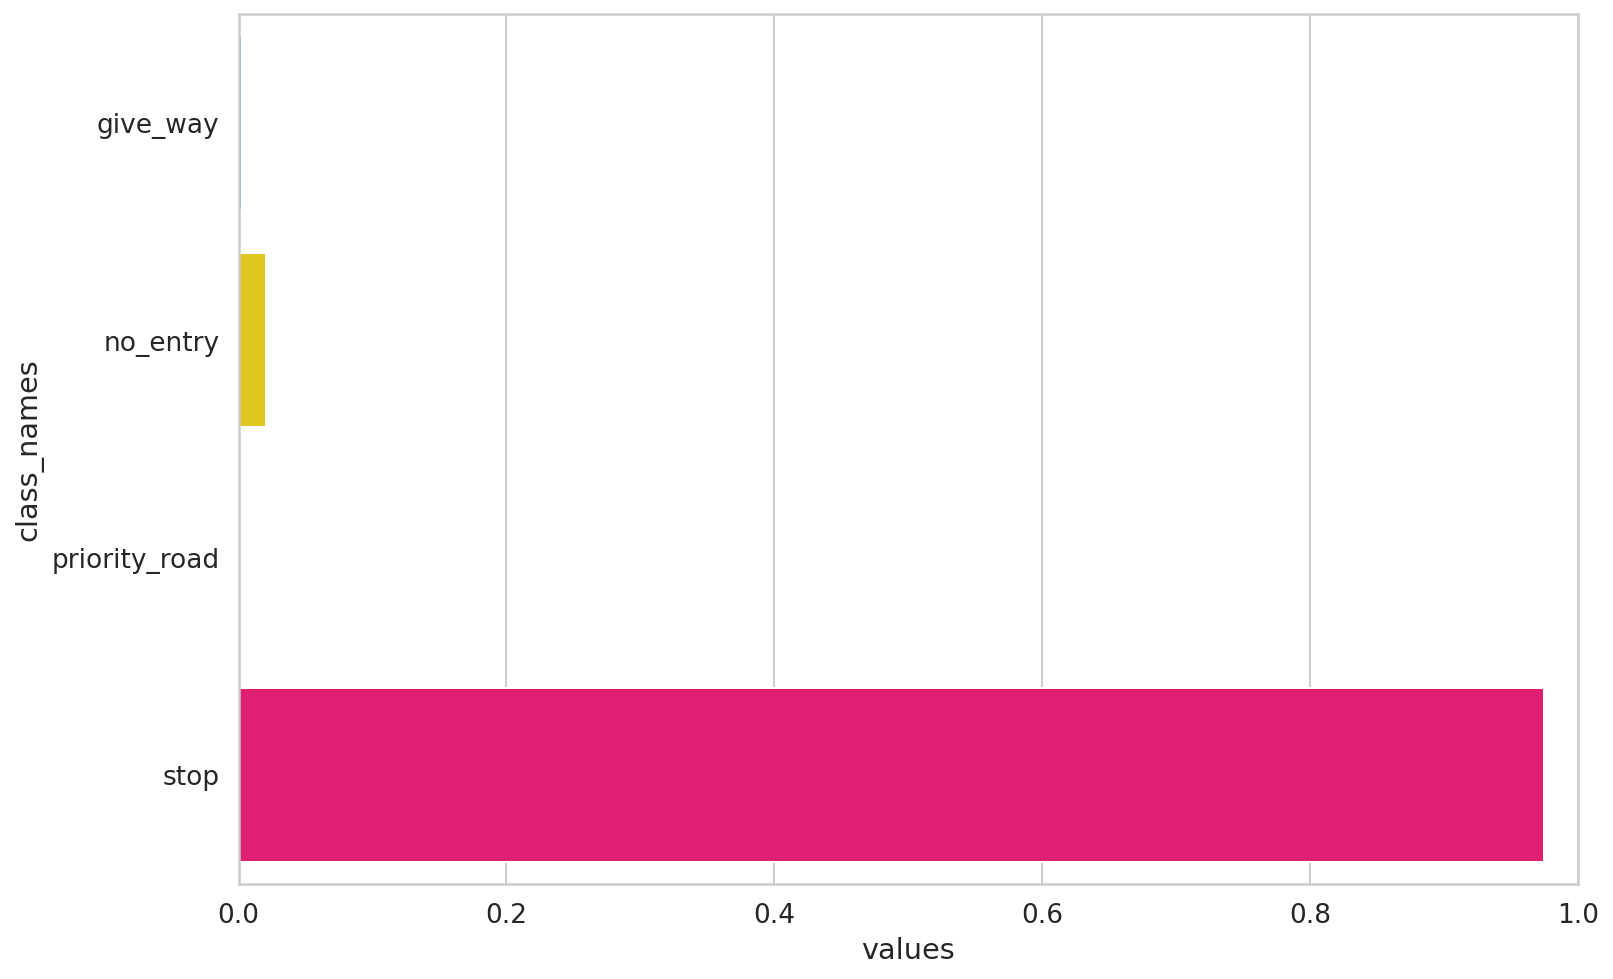

In [48]:
show_prediction_confidence(pred, class_names)

Again, our model is performing very well! Really confident in the correct traffic sign!

### Classyfing unknown traffic sign

The last challenge for our model is a traffic sign that it hasn't seen before:

In [49]:
!gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u

Downloading...
From: https://drive.google.com/uc?id=1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
To: /content/unknown-sign.jpg
100% 41.4k/41.4k [00:00<00:00, 65.9MB/s]


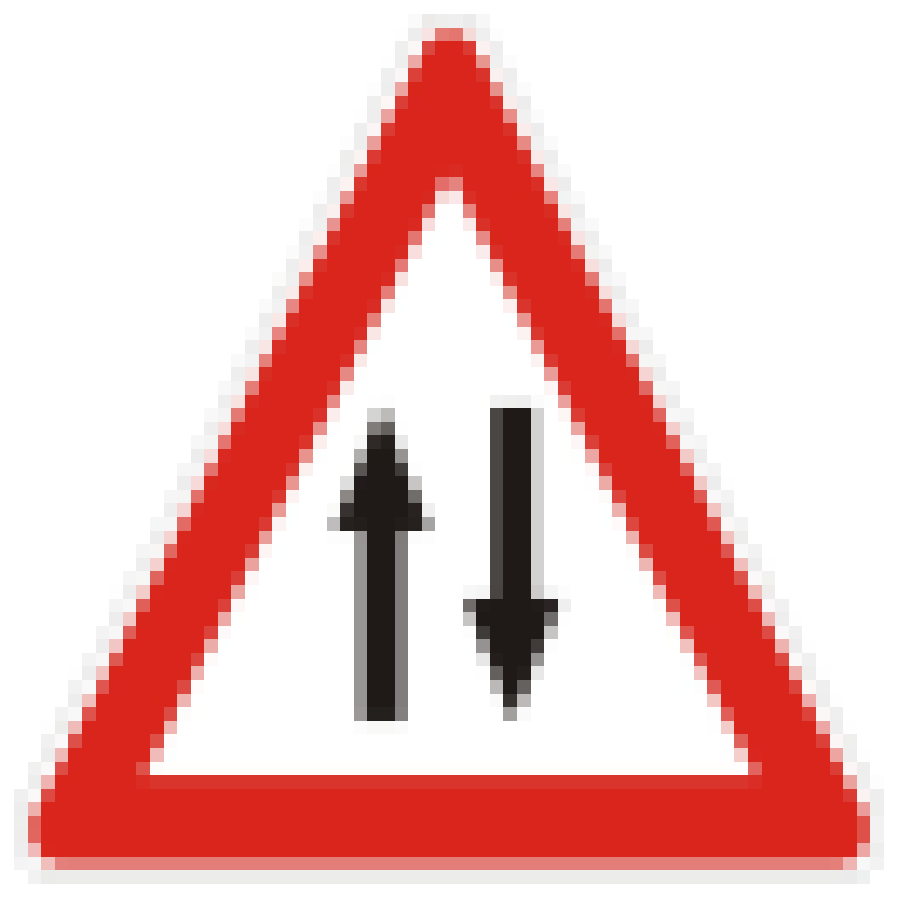

In [50]:
show_image('unknown-sign.jpg')

Let's get the predictions:

In [51]:
pred = predict_proba(base_model, 'unknown-sign.jpg')
pred

array([9.8481226e-01, 1.2167627e-04, 1.1895303e-02, 3.1708011e-03],
      dtype=float32)

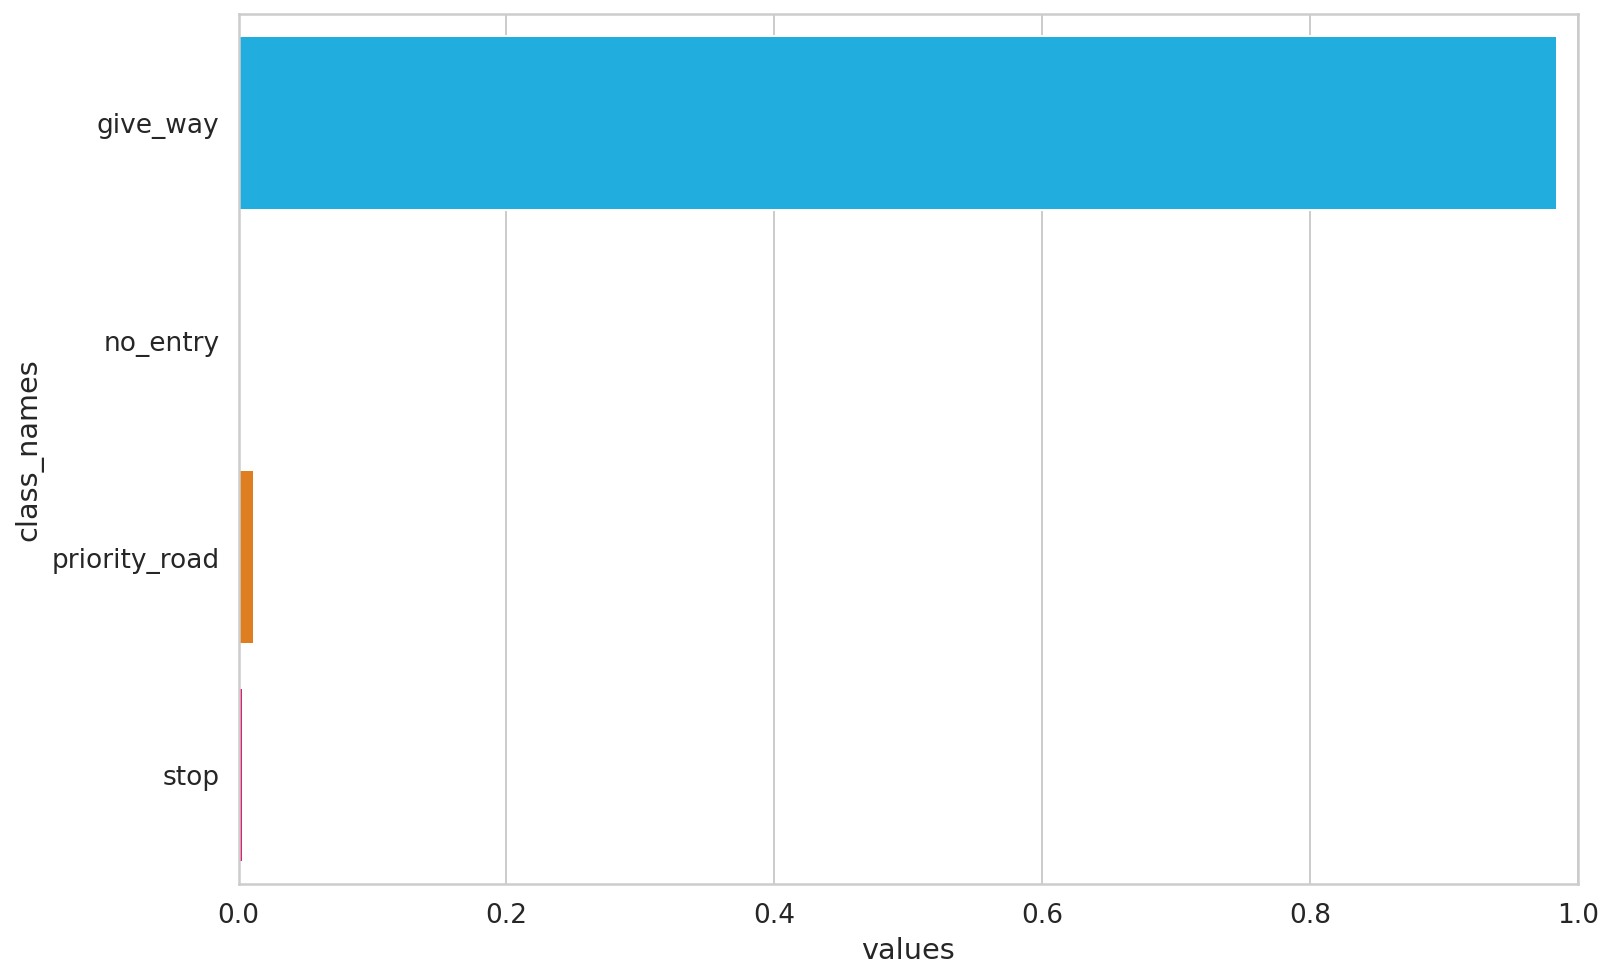

In [52]:
show_prediction_confidence(pred, class_names)

Our model is very certain (more than 98% confidence) that this is a *give way* sign. This is obviously wrong. How can you make your model see this?

## Adding class "unknown"

While there are a variety of ways to handle this situation (one described in this paper: [A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks](https://arxiv.org/pdf/1610.02136.pdf)), we'll do something simpler.

We'll get the indices of all traffic signs that weren't included in our original dataset:

In [53]:
unknown_indices = [
  i for i, f in enumerate(train_folders) \
  if i not in class_indices
]

len(unknown_indices)

39

We'll create a new folder for the unknown class and copy some of the images there:

In [54]:
for ds in DATASETS:
  (DATA_DIR / ds / 'unknown').mkdir(parents=True, exist_ok=True)

for ui in unknown_indices:
  image_paths = np.array(glob(f'{train_folders[ui]}/*.ppm'))
  image_paths = np.random.choice(image_paths, 50)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/unknown/')

The next steps are identical to what we've already done:

In [55]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 787, 'train': 5690, 'val': 786}

In [56]:
%%time

enchanced_model = create_model(len(class_names))
enchanced_model, history = train_model(enchanced_model, data_loaders, dataset_sizes, device)

Epoch 1/5
----------
Train loss 0.38617153440470653 accuracy 0.8659050966608085
Val   loss 0.030144307195053625 accuracy 0.989821882951654

Epoch 2/5
----------
Train loss 0.1707131581019405 accuracy 0.9456942003514939
Val   loss 0.01021929285427528 accuracy 0.9987277353689569

Epoch 3/5
----------
Train loss 0.10650878560923051 accuracy 0.9674868189806679
Val   loss 0.0072508289989045025 accuracy 0.9974554707379135

Epoch 4/5
----------
Train loss 0.08366721379874381 accuracy 0.971353251318102
Val   loss 0.0017091767554859127 accuracy 1.0

Epoch 5/5
----------
Train loss 0.07221922456717352 accuracy 0.9773286467486819
Val   loss 0.006000679770627796 accuracy 0.9974554707379135

Best val accuracy: 1.0
CPU times: user 3min 15s, sys: 9.14 s, total: 3min 24s
Wall time: 3min 27s


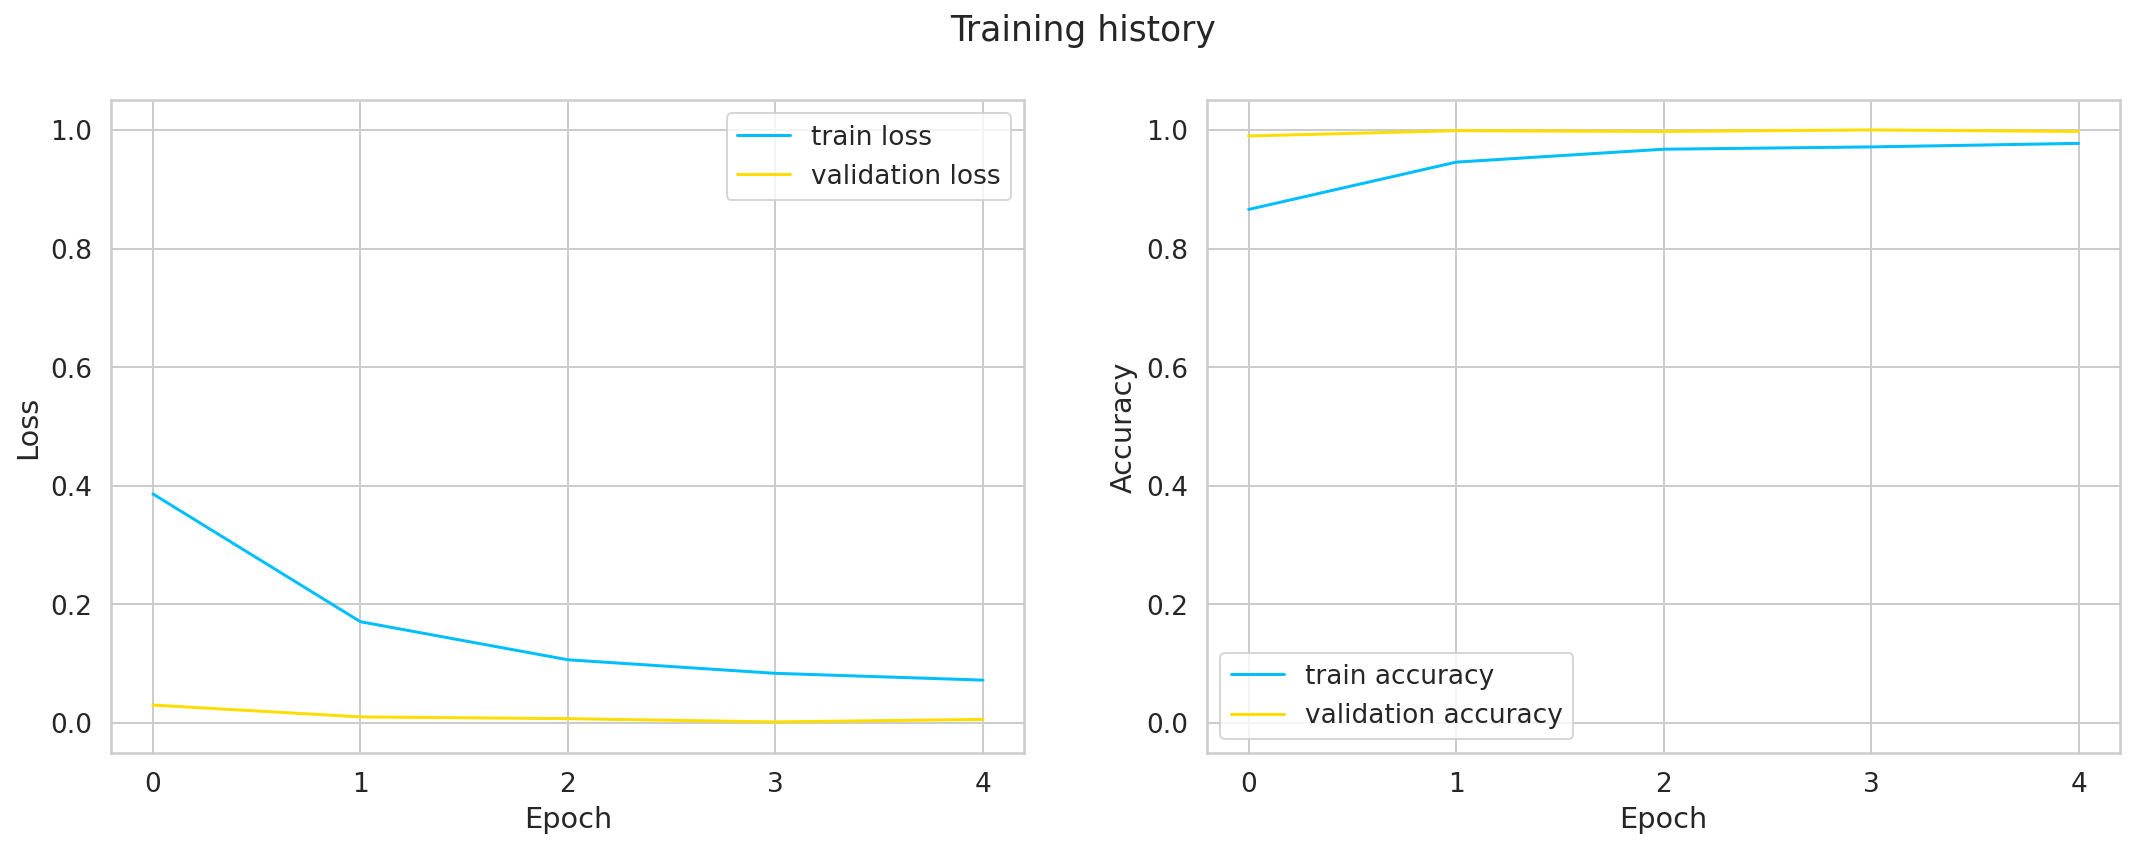

In [57]:
plot_training_history(history)

Again, our model is learning very quickly. Let's have a look at the sample image again:

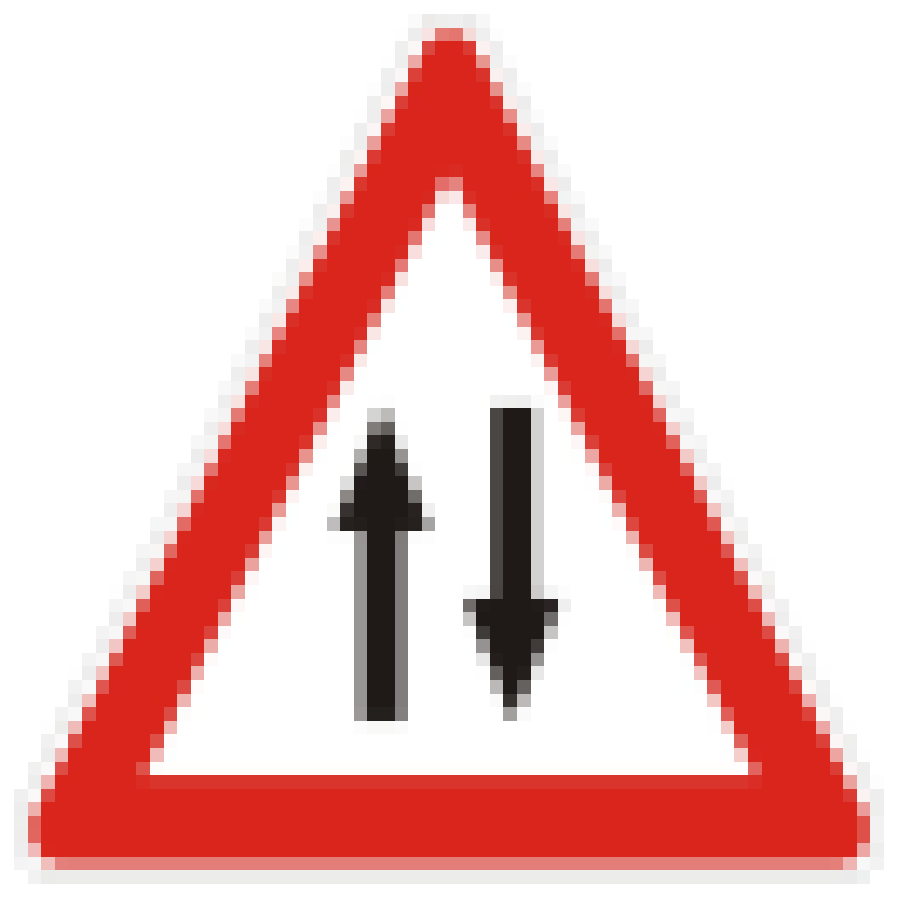

In [58]:
show_image('unknown-sign.jpg')

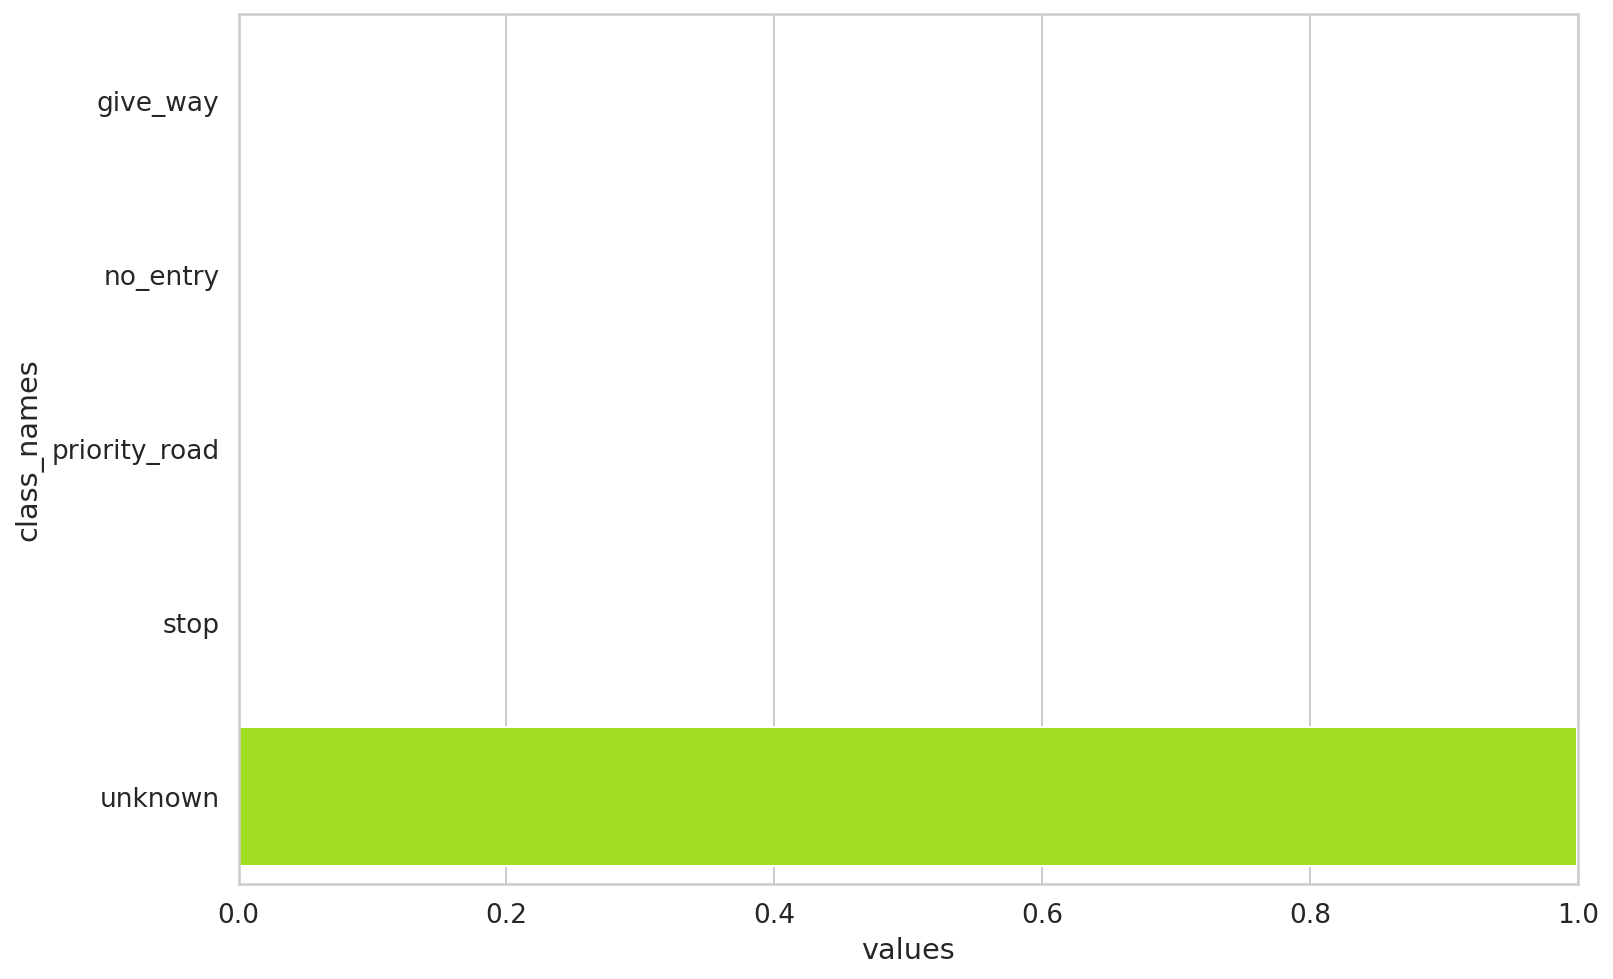

In [59]:
pred = predict_proba(enchanced_model, 'unknown-sign.jpg')
show_prediction_confidence(pred, class_names)

Great, the model doesn't give much weight to any of the known classes. It doesn't magically know that this is a two-way sign, but recognizes is as unknown.

Let's have a look at some examples of our new dataset:

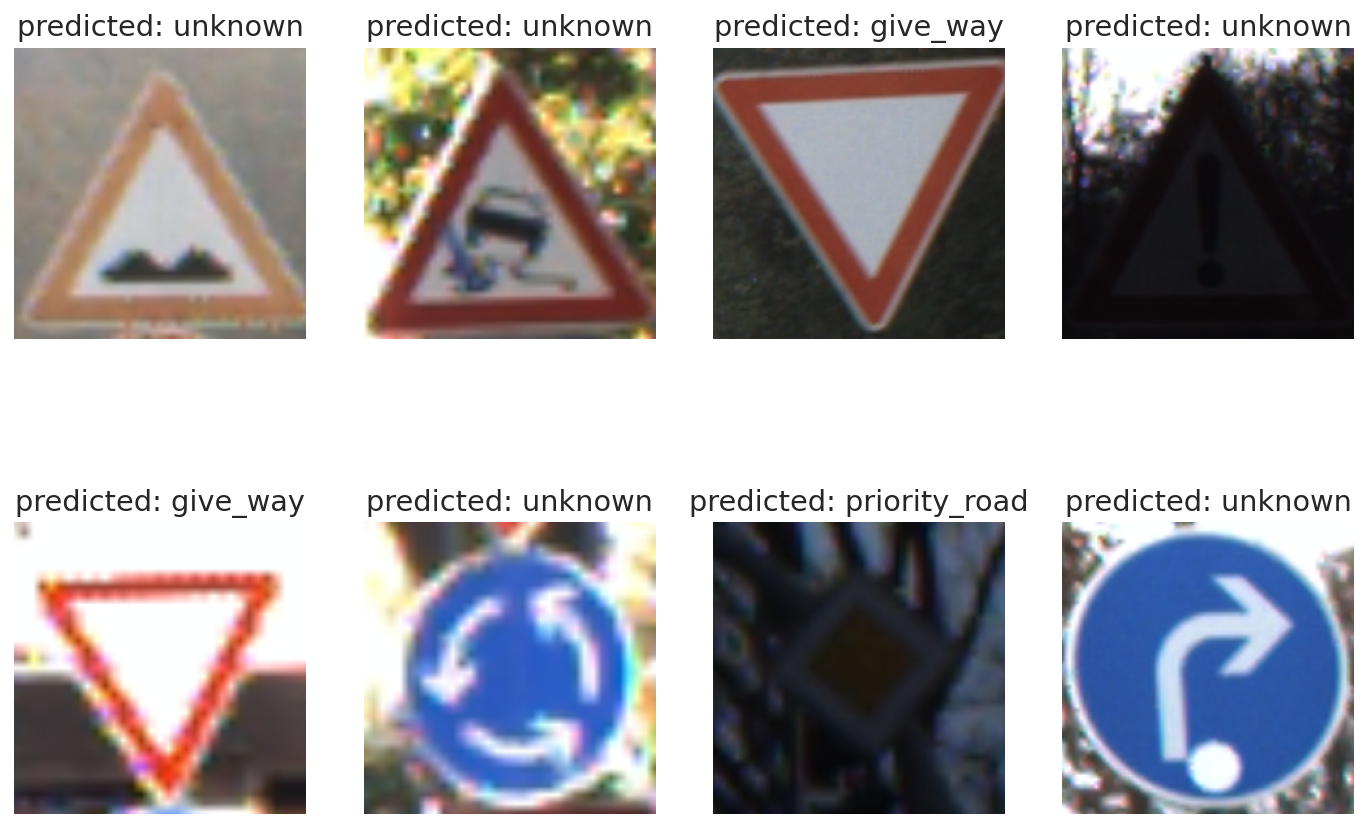

In [60]:
show_predictions(enchanced_model, class_names, n_images=8)

Let's get an overview of the new model's performance:

In [61]:
y_pred, y_test = get_predictions(enchanced_model, data_loaders['test'])

In [62]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       111
priority_road       1.00      1.00      1.00       210
         stop       1.00      1.00      1.00        78
      unknown       1.00      1.00      1.00       172

     accuracy                           1.00       787
    macro avg       1.00      1.00      1.00       787
 weighted avg       1.00      1.00      1.00       787



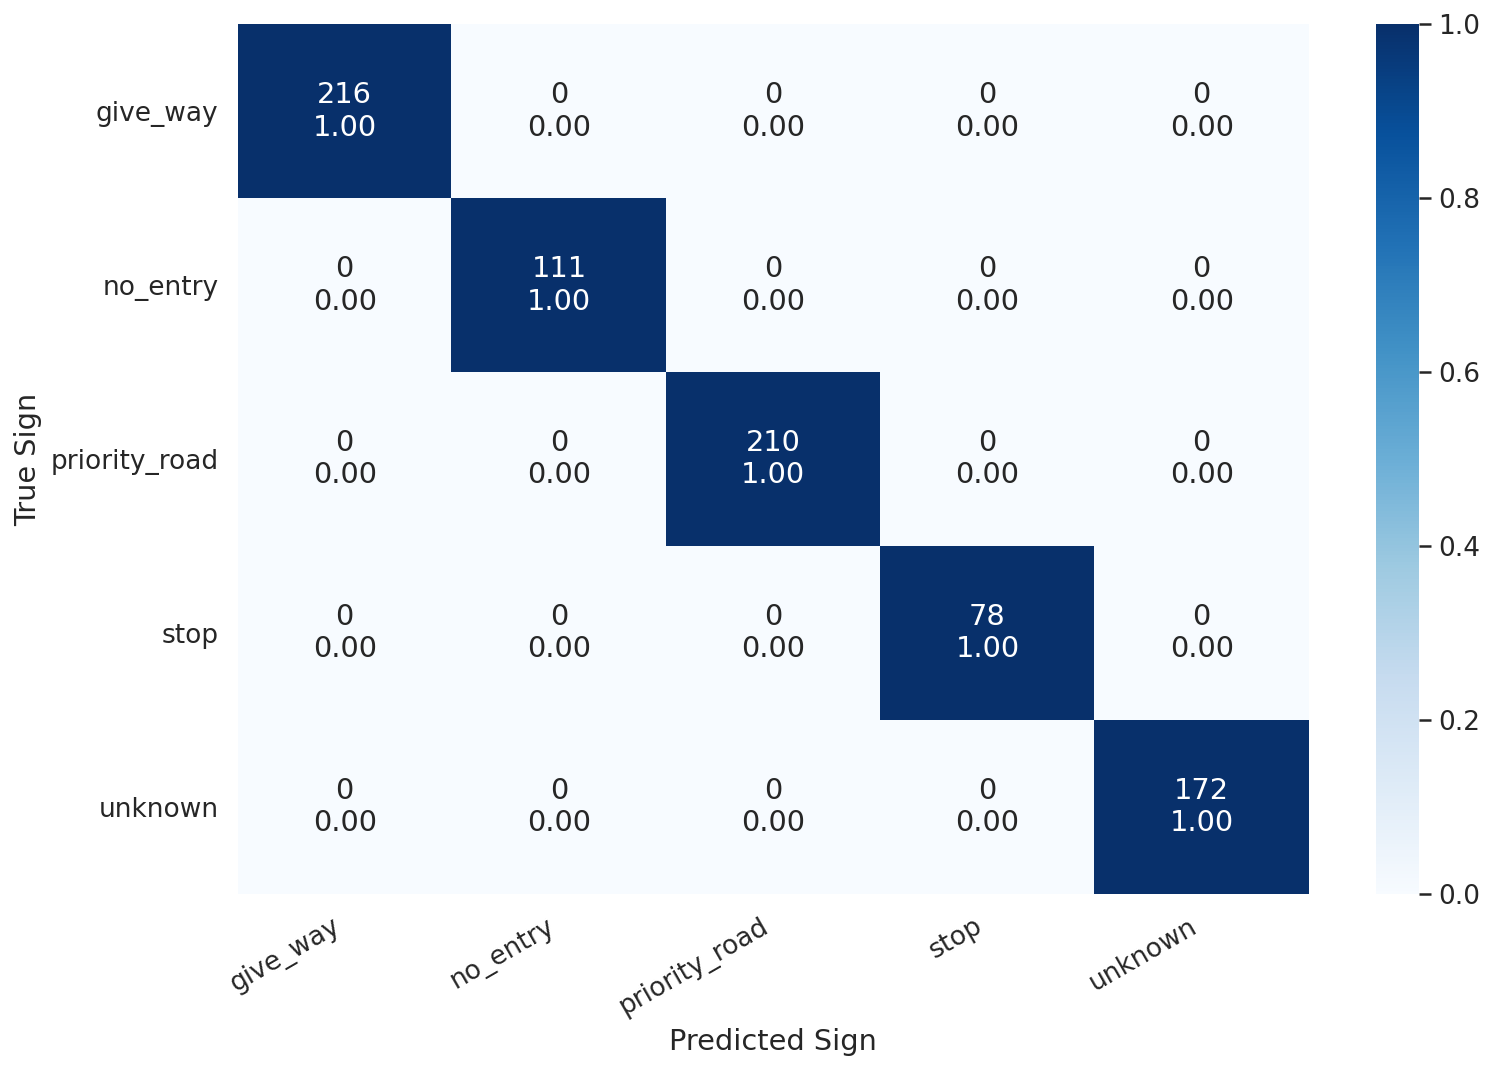

In [63]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

Our model is still perfect. Go ahead, try it on more images!

## Conclusion

We trained two different models for classifying traffic signs from raw pixels. We also built a dataset that is compatible with Torchvision.



Here's what we've learned:

- Overview of the traffic sign image dataset
- Build a dataset
- Use a pre-trained model from Torchvision
- Add a new *unknown* class and re-train the model



## References

- [ResNet: the intuition behind it](https://wiseodd.github.io/techblog/2016/10/13/residual-net/)
- [Understanding ResNet Intuitively](https://mc.ai/understanding-resnet-intuitively/)
- [Conv Nets: A Modular Perspective](https://colah.github.io/posts/2014-07-Conv-Nets-Modular/)
- [An intuitive guide to Convolutional Neural Networks](https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/)
- [A friendly introduction to Convolutional Neural Networks and Image Recognition](https://youtu.be/2-Ol7ZB0MmU?t=721)
- [A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks](https://arxiv.org/pdf/1610.02136.pdf)
- [How to Train an Image Classifier in PyTorch and use it to Perform Basic Inference on Single Images](https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5)
- [Transfer Learning with Convolutional Neural Networks in PyTorch](https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce)
- [Image Classification with Transfer Learning and PyTorch](https://stackabuse.com/image-classification-with-transfer-learning-and-pytorch/)

# Comparision of This Solution with that of Implemented in Mini-Project-3


* The dataset for mini-project was taken from kaggle and the samples looked imbalanced; whereas the dataset for final project was an official German Traffic sign dataset.

* In final project we are also **building dataset** from most famous 4 classes, while in mimi-project we used the whole dataset directly for the model

* The final project used transforms that are available in Torchvision for ***Data Augmentation*** to create new samples of Dataset; mini project did not use Data Augmentation.

* In Data Augmentation of final project we are doing **Cropping**, **Rotation**, **Horizontal Flipping** and **Resizing**.

* In final project we are doing **Normalization** which is expected by pre-trained model that are provided by the torchvision.

* In final project we are using a pretrained model which is available in the torchvision module which is called **ResNet** and there is a very deep neural network used in that. And in practice if we do this using convensional convolutional layers, you do not get better models because of vanishing gradients and curse of dimensionality problem.

* In final project we used 5 epochs to reach the expected accuracy, and in mini-project we used upto 15 epochs but it did not perform well as compared to final project.

* The Final Project performed **10% better** than the Mini-Project-3 in terms of accuracy.

